# 

## 1. Data loading and inspection of the manure dataset

This notebook outlines the inspection, analysis, and cleaning of the manure.csv dataset to ensure it is ready for further modeling and analysis. The main goal is to improve data quality by identifying and addressing inconsistencies, outliers, and missing values using both statistical methods and domain knowledge.

The workflow includes four key steps:

1. Data Inspection

Load manure_std_cons.csv into a pandas DataFrame.

Inspect data types, null values, and structure using .info().

2. Descriptive Statistics & Outlier Detection

Generate detailed statistics with ydata-profiling.

Visualize distributions and outliers with boxplots.

Use z-scores to detect prominent outliers in numerical variables.

3. Data Cleaning & Transformation

Standardize column names for consistency and readability.

Clean categorical variables by correcting typos and duplicates.

Address gaps and outliers in numerical variables using statistical methods and agronomic knowledge.

Standardize units.

4. Final Review and File Export

Recompute descriptive statistics to confirm that issues are resolved.

Ensure the dataset is consistent, reliable, and ready for further enrichment and modeling.

This structured approach guarantees a clean, consistent, and enriched dataset, providing a strong foundation for robust analysis.

In [44]:
# import libraries
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from scipy import stats

# for static plots
%matplotlib inline

The first step in the process is to load and quickly inspect the main dataset

In [45]:
# read manure dataset
manure = pd.read_csv('../Data/manure.csv')
# Preview
manure.head()

,HHID,OrgFert_Name_2024,OrgFert_Quantity_2024,OrgFert_Unit_2024
0,398,Farmyard manure,15,Wheelbarows
1,397,Farmyard manure,15,Wheelbarows
2,395,Farmyard manure,20,Wheelbarows
3,370,Farmyard manure,25,Wheelbarows
4,370,Farmyard manure,30,Wheelbarows


The preview of the dataset allow us to see that we are dealing with a wide dataframe, that has data related oganic ferilizer name, quantity and unit.

### Insights: 

- The dataset includes a field with household ids useful to identify and correctly identify each datapoint.
- Most of the variable names have capital letters and lower case letters
- The dataset includes numerical data and categorical data

The second step in the inspection is to show more generalized information on the shape of the dataset (number of variables, number of datapoints), missing values, and data types for each variable.

In [46]:
manure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   HHID                   75 non-null     int64 
 1   OrgFert_Name_2024      75 non-null     object
 2   OrgFert_Quantity_2024  75 non-null     int64 
 3   OrgFert_Unit_2024      75 non-null     object
dtypes: int64(2), object(2)
memory usage: 2.5+ KB


### Insights:

- The dataset has 4 variables (columns) and 75 datapoints (rows)
- There are 2 integer data type variables
- There are 2 object (text, boolean, levels, categories) data type variables

## 2. Descriptive statistics of the manure dataset

The next step is to generate a more detailed statistical profile of the data to uncover additional insights and potential issues. We use the YData library, which produces a comprehensive report of descriptive statistics, including interactive exploration and automatic visualizations, with a single line of code.

In [47]:

profile_manure = ProfileReport(manure, title="Manure Data Profiling Report")
#profile_manure.to_file("report.html")  # HTML report
profile_manure.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 9642.08it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Insights:
**Numerical**
- OrgFert_Quantity_2024: is the only relevant numerical variable, with a mean organic fertilizer usage of 49.49 units in 2024, it shows a significant standard deviation of 56.73. A maximum value of 400.

**Categorical** 

- Organic fertilizer diversity: Only 3 distinct fertilizer types are used, with Farmyard manure being the dominant one (61% of records).

- Measurement variation: Fertilizer is reported in 6 different units, which may create comparability issues across households.

- Unit dominance: Wheelbarrows is the most common unit (71% of cases), suggesting it’s the standard reference for most farmers.

### Possible data errors/issues:

- HHIDs duplicated row requires cleaning
- Duplicated HHIDs with differing information on other columns

### Oportunities to enhance the data

- Units should be standardized
- Fertilizer quantity should be standardized


We then proceed to analyze potential outliers in the dataset.

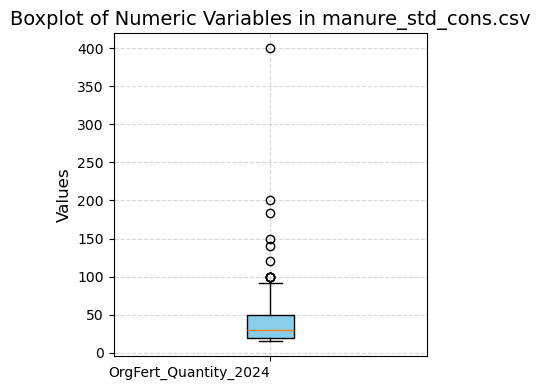

In [48]:

# Drop HHID column and select numeric columns only
manure_numeric = manure_no_hhid.select_dtypes(include='number')

# Create boxplot
fig, ax = plt.subplots(figsize=(4, 4))

box = ax.boxplot(
    [manure_numeric[col].dropna() for col in manure_numeric.columns],
    patch_artist=True,
    boxprops=dict(facecolor='skyblue')  # All boxes in skyblue
)

# Titles and labels
ax.set_title('Boxplot of Numeric Variables in manure_std_cons.csv', fontsize=14)
ax.set_ylabel('Values', fontsize=12)
ax.set_xticks(range(1, len(manure_numeric.columns) + 1))
ax.set_xticklabels(manure_numeric.columns, ha='right', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


The boxplot highlights outliers among the numeric variables. At this stage, we lack additional context to interpret these extreme values. We will address the outliers after merging the main and manure datasets.

In [49]:
#zscore
outlier_df = pd.concat([manure[(np.abs(stats.zscore(manure[col].dropna())) > 2).reindex(manure.index, fill_value=False)].assign(outlier_column=col) for col in manure.select_dtypes(include=[np.number])])
outlier_df[outlier_df['outlier_column']== 'OrgFert_Qantity_2024']

,HHID,OrgFert_Name_2024,OrgFert_Quantity_2024,OrgFert_Unit_2024,outlier_column


Using the Z-score statistic, no outliers are detected. We will better contextualize the values once the main and manure datasets are merged.

## 3. Data cleaning and transformation

The first step in data cleaning and transformation is to create a copy of the original dataset, ensuring changes can be easily reverted if needed. Next, based on insights from previous steps, we will standardize the column names.

In [50]:
manure.columns = manure.columns.str.lower()
print(manure.columns.tolist())

['hhid', 'orgfert_name_2024', 'orgfert_quantity_2024', 'orgfert_unit_2024']


The next step is to remove duplicate rows from the dataset.

In [51]:
# Remove duplicated rows
manure_std = manure.copy()

# Check for duplicates before removal
duplicates_before = manure_std.duplicated().sum()
print(f"Number of duplicate rows found in original dataset: {duplicates_before}")

if duplicates_before > 0:
    print("\nSample of duplicate rows:")
    print(manure_std[manure_std.duplicated()].head())
else:
    print("No duplicate rows found in the original dataset.")

# Remove duplicates
manure_std = manure_std.drop_duplicates()

# Check for duplicates after removal
duplicates_after = manure_std.duplicated().sum()
print(f"\nNumber of duplicate rows after removal: {duplicates_after}")

# Print final shape comparison
print(f"\nDataset shape change:")
print(f"Rows removed: {len(manure) - len(manure_std)}")

Number of duplicate rows found in original dataset: 1

Sample of duplicate rows:
    hhid orgfert_name_2024  orgfert_quantity_2024 orgfert_unit_2024
74     6   Farmyard manure                     20       Wheelbarows

Number of duplicate rows after removal: 0

Dataset shape change:
Rows removed: 1


Next, we standardize the organic fertilizer units by creating a conversion factor map and calculating the standardized fertilization quantities in kilograms. 

The unit conversions for organic fertilizer—such as 20 L bucket/debe, and 65 L wheelbarrows—are based on estimated weights to standardize quantities.

In [52]:
# see unit values in the dataframe
print("Unique values in orgfert_unit_2024 column:")
print(manure_std['orgfert_unit_2024'].unique())

# Create a standardized version of the unit column for matching
manure_std['orgfert_unit_2024_std'] = manure_std['orgfert_unit_2024'].astype(str).str.lower().str.strip()

# preview cleaned values
print("\nCleaned unique values:")
print(manure_std['orgfert_unit_2024'].unique())

# Conversion factors based on the cleaned units
conversion_factors_manure = {
    'kg': 1,
    '25 kg bag': 25,
    'bucket/debe': 20, # weight estimated for a standard 20L bucket
    'ton': 1000,
    '90 kg bag': 90,
    'wheelbarows':40.  # weight estimated for a standard 65L wheelbarow
}

# Apply conversion using the cleaned column
manure_std['orgfert_quantity_2024_kg'] = manure_std['orgfert_quantity_2024'] * manure_std['orgfert_unit_2024_std'].map(conversion_factors_manure)

# Check for any missing values (units not in our conversion map)
missing_mask = manure_std['orgfert_quantity_2024_kg'].isna()
if missing_mask.any():
    print(f"\nWarning: {missing_mask.sum()} records had units not found in conversion map:")
    print(manure_std[missing_mask]['orgfert_unit_2024_std'].unique())
    
    # Fill missing values with original quantity
    manure_std.loc[missing_mask, 'orgfert_quantity_2024_kg'] = manure_std.loc[missing_mask, 'orgfert_quantity_2024']

# Check the results
print("\nConversion results:")
manure_std.tail(10)

Unique values in orgfert_unit_2024 column:
['Wheelbarows' 'Kg' '25 Kg bag' 'Bucket/Debe' 'Ton' '90 Kg bag']

Cleaned unique values:
['Wheelbarows' 'Kg' '25 Kg bag' 'Bucket/Debe' 'Ton' '90 Kg bag']

Conversion results:


,hhid,orgfert_name_2024,orgfert_quantity_2024,orgfert_unit_2024,orgfert_unit_2024_std,orgfert_quantity_2024_kg
64,27,Farmyard manure,40,Wheelbarows,wheelbarows,1600.0
65,27,Compost,50,Wheelbarows,wheelbarows,2000.0
66,18,Farmyard manure,25,25 Kg bag,25 kg bag,625.0
67,18,Farmyard manure,15,Wheelbarows,wheelbarows,600.0
68,15,Compost,60,Wheelbarows,wheelbarows,2400.0
69,14,Compost,200,Kg,kg,200.0
70,14,Farmyard manure,50,Wheelbarows,wheelbarows,2000.0
71,8,Compost,150,Kg,kg,150.0
72,8,Compost,16,Wheelbarows,wheelbarows,640.0
73,6,Farmyard manure,20,Wheelbarows,wheelbarows,800.0


The next step is to analyze and resolve duplicated household IDs that contain differing information on fertilizer quantities and types.

In [53]:
duplicates_manure = manure[manure.duplicated(subset=['hhid'], keep=False)]
print(duplicates_manure)

    hhid orgfert_name_2024  orgfert_quantity_2024 orgfert_unit_2024
3    370   Farmyard manure                     25       Wheelbarows
4    370   Farmyard manure                     30       Wheelbarows
6    354           Compost                     15       Wheelbarows
7    354           Compost                     40       Wheelbarows
9    337   Farmyard manure                     60       Wheelbarows
10   337   Farmyard manure                     92       Wheelbarows
29   199   Farmyard manure                     20               Ton
30   199   Farmyard manure                     28               Ton
31   195   Farmyard manure                     20       Wheelbarows
32   195   Farmyard manure                    400       Wheelbarows
37   172           Compost                     40       Wheelbarows
38   172   Farmyard manure                    100                Kg
40   155   Farmyard manure                     30               Ton
41   155           Compost                     2



After examining the duplicated rows, we infer that these are unlikely to be errors and may represent multiple reports from the same households, such as two rounds of fertilization. 

Since it is not possible at this stage to confirm with the data collection or field teams, we assume that the data reflects two application rounds and proceed to aggregate the quantities by summing them. 

In an ideal scenario, this issue would be clarified through feedback from the data collection or survey design teams.

To keep record of the original values, we create new columns where:

- orgfert_qty_2024_kg_total: is the sum of fertilizer quantities, if household is not duplicated the sum will be equal to orgfert_qty_2024_kg

- orgfert_names_2024: a string of the fertilizer(s) reported

- orgfert_qty_2024_kg: a list of fertilizer(s) quantities applied


In [54]:
manure_std_cons = manure_std.groupby("hhid").agg(
    orgfert_qty_2024_kg_total=("orgfert_quantity_2024_kg", "sum"),
    orgfert_names_2024=("orgfert_name_2024", lambda x: ", ".join(map(str, x))),
    orgfert_qty_2024_kg=("orgfert_quantity_2024_kg", lambda x: ", ".join(map(str, x)))
).reset_index()
manure_std_cons.head()

,hhid,orgfert_qty_2024_kg_total,orgfert_names_2024,orgfert_qty_2024_kg
0,6,800.0,Farmyard manure,800.0
1,8,790.0,"Compost, Compost","150.0, 640.0"
2,14,2200.0,"Compost, Farmyard manure","200.0, 2000.0"
3,15,2400.0,Compost,2400.0
4,18,1225.0,"Farmyard manure, Farmyard manure","625.0, 600.0"


## 4. Final Review and File Export

To finalize, we run the descriptive statics report to check results

In [55]:
manure_stats_cols = ['orgfert_qty_2024_kg_total','orgfert_names_2024']
profile_manure_cons = ProfileReport(manure_std_cons[manure_stats_cols], title="Manure Standarized Data Profiling Report")
#profile_manure.to_file("report.html")  # HTML report
profile_manure_cons.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 1237.81it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

The last step in the analisys is to save the cleaned manure data set as csv file

In [56]:
manure_std_cons.to_csv('../data/cleaned/manure_std_cons.csv', index=False)

The analysis continues with the 3_descriptive_stats_cleaning_merged.ipynb notebook.